# ALGORITMOS BASADOS EN SERIES TEMPORALES

## 3.) Modelos ARIMA con Componentes Estacionales (SARIMA)
El modelo SARIMA (Seasonal Autoregressive Integrated Moving Average) es una extensión del modelo ARIMA que incorpora patrones estacionales y se basa en valores anteriores de la serie temporal.

### Estructura del modelo SARIMA(p, d, q)(P, D, Q, s):
* (p, d, q) → Componentes autoregresivos, diferenciales y de media móvil.
* (P, D, Q, s) → Componentes estacionales con periodicidad 𝑠 (en este caso, s=12 meses).

Este modelo aprende la relación entre:
* Ventas recientes (p).
* Tendencias de largo plazo (d).
* Variaciones estacionales mensuales (P, D, Q, s).

### 📌 SARIMA es adecuado cuando la demanda tiene estacionalidad anual y fluctuaciones a corto plazo.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from pmdarima.arima import auto_arima
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pyodbc
from dotenv import dotenv_values

# Mostrar los resultados
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
print("numpy version:", np.__version__)

import pmdarima
print("ARIMA version:",pmdarima.__version__)


numpy version: 1.26.4
ARIMA version: 2.0.4


In [3]:
# ELEGIR el PROVEEDOR
proveedor = 327
label = '327_Paladini'

In [4]:
# INICIAR CON EL PROVEEDOR

# Cargar Datos
data = pd.read_csv(f'data/{label}.csv')
data.head()

# Adecuar Tipos de Datos
data['Sucursal']= data['Sucursal'].astype(int)
data['Familia']= data['Familia'].astype(int)
data['Rubro']= data['Rubro'].astype(int)
data['SubRubro']= data['SubRubro'].astype(int)
data['Clasificacion']= data['Clasificacion'].astype(int)
data['Codigo_Articulo']= data['Codigo_Articulo'].astype(int)
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Convertir a formato datetime si aún no lo está
data.sort_values(by='Fecha', ascending=True)  # Ordenar por fecha de menor a mayor

# Crear una nueva columna con el mes y el año para análisis temporal
data['Año-Mes'] = data['Fecha'].dt.to_period('M')

# Crear una nueva columna con el formato Año-Semana (AAAA-WW) a partir de la columna Fecha
data['Año-Semana'] = data['Fecha'].dt.strftime('%Y-%W')

# Confirmar que la columna sigue siendo un campo datetime
#print(data.dtypes)

#data = data.sort_values(by='Fecha', ascending=True)  # Ordenar en orden ascendente (del más antiguo al más reciente)
#data = data.reset_index()

# Recortar Cantidad de Datos ULTIMO AÑO COMPLETO
df = data[data['Fecha']>='2021-01-01']

In [49]:
# Recortar Cantidad de Datos ULTIMOS 30 MESES COMPLETOS (Para que TRAIN tenga 24 meses mínimo)
df = data[data['Fecha']>='2022-06-01']

### 🔹 Explicación del Código
#### 📊 Preprocesamiento de datos
* Se agruparon las ventas mensuales por artículo y sucursal.
* Se seleccionó un producto y sucursal específicos para entrenar el modelo.
* Se convirtió el DataFrame en una serie temporal con frecuencia mensual (asfreq('M')).

#### 🔎 Selección de Parámetros Automáticos con auto_arima
* auto_arima(train, seasonal=True, m=12, trace=True) encuentra automáticamente los mejores parámetros (p, d, q) y (P, D, Q, s) considerando estacionalidad mensual (m=12).
#### 📈 Entrenamiento del Modelo SARIMA
* Se usa SARIMAX de statsmodels con los parámetros encontrados.
* Se entrena el modelo en los datos históricos de ventas.
#### 📊 Predicción y Evaluación
* Se generan predicciones para el conjunto de prueba.
* Se calculan métricas de error:
* MAE (Error Absoluto Medio)
* RMSE (Raíz del Error Cuadrático Medio)
#### 📉 Visualización
Se grafica la serie original junto con las predicciones para ver la precisión del modelo.


### Revisar:
* ✅ SARIMA es ideal cuando hay patrones estacionales fuertes en la demanda.
* ✅ Este modelo mejora la precisión al incorporar información del año pasado y la tendencia de corto plazo.
* ✅ Se puede entrenar un SARIMA diferente para cada producto y sucursal, o usar técnicas más avanzadas como modelos de series temporales múltiples (VAR, Prophet, LSTM) si tienes muchos productos.

¡Puedes probarlo en tus datos y ver qué tan bien predice la demanda en cada tienda 🚀

In [50]:
# PREPROCESAR LOS DATOS Agrupando por MES

# Asegurar que 'Año-Mes' está en formato datetime
df['Año-Mes'] = pd.to_datetime(df['Año-Mes'].astype(str))

# Convertir Codigo_Articulo y Sucursal a int32 en el DataFrame original Puto Error de Tipo de Datos -- Me volvió LOCO !!!!
df['Codigo_Articulo'] = df['Codigo_Articulo'].astype('int32')
df['Sucursal'] = df['Sucursal'].astype('int32')

# Agrupar las ventas mensuales por artículo y sucursal
df_ventas_mensuales = df.groupby(['Año-Mes', 'Codigo_Articulo', 'Sucursal'])['Unidades'].sum().reset_index()
df_ventas_mensuales['Año-Mes'] = df_ventas_mensuales['Año-Mes'] + pd.offsets.MonthEnd(0)

# Asegurar que Codigo_Articulo y Sucursal son int32 en df_ventas_mensuales
df_ventas_mensuales['Codigo_Articulo'] = df_ventas_mensuales['Codigo_Articulo'].astype('int32')
df_ventas_mensuales['Sucursal'] = df_ventas_mensuales['Sucursal'].astype('int32')

# Verificar artículos y sucursales disponibles
#print(df_ventas_mensuales[['Codigo_Articulo', 'Sucursal']].drop_duplicates())
# Seleccionar un código de artículo y sucursal que tengan datos
codigo_articulo = df_ventas_mensuales['Codigo_Articulo'].value_counts().idxmax()
sucursal = df_ventas_mensuales['Sucursal'].value_counts().idxmax()

C:\Users\eduar\AppData\Local\Temp\ipykernel_37656\3402475563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Año-Mes'] = pd.to_datetime(df['Año-Mes'].astype(str))
C:\Users\eduar\AppData\Local\Temp\ipykernel_37656\3402475563.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Codigo_Articulo'] = df['Codigo_Articulo'].astype('int32')
C:\Users\eduar\AppData\Local\Temp\ipykernel_37656\3402475563.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [52]:
# FILTRAR POR ARTÍCULO SUCURSAL PARA REALIZAR LA ESTIMACIÓN

# codigo_articulo = df_ventas_mensuales['Codigo_Articulo'].unique()[0]  # Cambia el índice si está vacío
# sucursal = df_ventas_mensuales['Sucursal'].unique()[0]  # Cambia el índice si está vacío

# Filtrar el DataFrame

df_filtrado = df_ventas_mensuales[
    (df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) &
    (df_ventas_mensuales['Sucursal'] == sucursal)
]

# Verificar si la combinación seleccionada tiene datos
if df_filtrado.empty:
    raise ValueError("No hay datos para la combinación seleccionada. Cambia los valores de 'codigo_articulo' y 'sucursal'.")

# Convertir en serie temporal con 'Año-Mes' como índice
df_filtrado.set_index('Año-Mes', inplace=True)

# Asegurar frecuencia mensual  para que queden en el último día dely eliminar NaNs
df_filtrado = df_filtrado.asfreq('ME').fillna(0)

# Convertir nuevamente las columnas a int32 después de la conversión - No me va a agarrar de Nuevo !!!!!
df_filtrado['Codigo_Articulo'] = df_filtrado['Codigo_Articulo'].astype('int32')
df_filtrado['Sucursal'] = df_filtrado['Sucursal'].astype('int32')

# Verificar después de la transformación
print(df_filtrado.head())


            Codigo_Articulo  Sucursal  Unidades
Año-Mes                                        
2022-06-30             7660         1     808.0
2022-07-31             7660         1     256.0
2022-08-31             7660         1     592.0
2022-09-30             7660         1     171.0
2022-10-31             7660         1     524.0


### Control de Consistencia de DATOS

In [ ]:
df_ventas_mensuales.info()
df_filtrado.info()
df.info()

In [ ]:
print("Combinaciones únicas en df_ventas_mensuales:")
print(df_ventas_mensuales[['Codigo_Articulo', 'Sucursal']].drop_duplicates())


In [ ]:
print(f"Artículo seleccionado: {codigo_articulo}")
print(f"Sucursal seleccionada: {sucursal}")

existe = ((df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) &
          (df_ventas_mensuales['Sucursal'] == sucursal)).any()

print(f"¿Existe esta combinación en df_ventas_mensuales? {existe}")


In [54]:
df_filtrado = df_ventas_mensuales[
    (df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) &
    (df_ventas_mensuales['Sucursal'] == sucursal)
]

print("Registros encontrados antes de `set_index()`:")
print(df_filtrado.head())  # Si está vacío aquí, el problema está en el filtrado.


Registros encontrados antes de `set_index()`:
        Año-Mes  Codigo_Articulo  Sucursal  Unidades
91   2022-06-30             7660         1     808.0
614  2022-07-31             7660         1     256.0
1164 2022-08-31             7660         1     592.0
1706 2022-09-30             7660         1     171.0
2252 2022-10-31             7660         1     524.0


In [55]:
print("Valores únicos en Año-Mes antes de `set_index()`:")
print(df_filtrado['Año-Mes'].unique())  # Debería mostrar fechas en formato datetime64

df_filtrado.set_index('Año-Mes', inplace=True)

print("Verificar índice después de `set_index()`:")
print(df_filtrado.index)  # Debe mostrar fechas válidas


Valores únicos en Año-Mes antes de `set_index()`:
<DatetimeArray>
['2022-06-30 00:00:00', '2022-07-31 00:00:00', '2022-08-31 00:00:00',
 '2022-09-30 00:00:00', '2022-10-31 00:00:00', '2022-11-30 00:00:00',
 '2022-12-31 00:00:00', '2023-01-31 00:00:00', '2023-02-28 00:00:00',
 '2023-03-31 00:00:00', '2023-04-30 00:00:00', '2023-05-31 00:00:00',
 '2023-06-30 00:00:00', '2023-07-31 00:00:00', '2023-08-31 00:00:00',
 '2023-09-30 00:00:00', '2023-10-31 00:00:00', '2023-11-30 00:00:00',
 '2023-12-31 00:00:00', '2024-01-31 00:00:00', '2024-02-29 00:00:00',
 '2024-03-31 00:00:00', '2024-04-30 00:00:00', '2024-05-31 00:00:00',
 '2024-06-30 00:00:00', '2024-07-31 00:00:00', '2024-08-31 00:00:00',
 '2024-09-30 00:00:00', '2024-10-31 00:00:00', '2024-11-30 00:00:00',
 '2024-12-31 00:00:00', '2025-01-31 00:00:00', '2025-02-28 00:00:00']
Length: 33, dtype: datetime64[ns]
Verificar índice después de `set_index()`:
DatetimeIndex(['2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '

In [56]:
print("Cantidad de filas antes de `asfreq()`:", len(df_filtrado))
df_filtrado = df_filtrado.asfreq('ME')
print("Cantidad de filas después de `asfreq()`:", len(df_filtrado))


Cantidad de filas antes de `asfreq()`: 33
Cantidad de filas después de `asfreq()`: 33


In [ ]:
# df_ventas_mensuales['Codigo_Articulo'] == 44460

### INICIO del ENTRENAMIENTO

In [ ]:
# DIVIDIR LOS DATOS

# Asegurar que el dataframe esté ordenado por fecha antes del split
df_filtrado = df_filtrado.sort_index()

# Dividir en datos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df_filtrado) * 0.8)

# Hacer la división asegurando orden temporal
train = df_filtrado.iloc[:train_size]  # Primer 80% de los datos (histórico)
test = df_filtrado.iloc[train_size:]  # Último 20% (futuro)

# Verificar los rangos de fecha
print(f"🔹 Train: {train.index.min()} → {train.index.max()}")
print(f"🔹 Test: {test.index.min()} → {test.index.max()}")

# Confirmar que la última fecha de train es justo antes de la primera fecha de test
assert train.index.max() < test.index.min(), "❌ Error: Hay solapamiento en train y test."


            Codigo_Articulo  Sucursal  Unidades
Año-Mes                                        
2022-06-30             7660         1     808.0
2022-07-31             7660         1     256.0
2022-08-31             7660         1     592.0
2022-09-30             7660         1     171.0
2022-10-31             7660         1     524.0


#### 1️⃣ Revisar los datos antes de entrenar SARIMA
* Antes de entrenar, verifica que train['Unidades'] tenga un patrón claro:

* Si la serie parece demasiado plana o con demasiado ruido, SARIMA no podrá ajustarse bien.

##### ✅ Si no hay una tendencia clara, prueba aplicar una transformación:

In [68]:
# Verificar la estructura de train antes de pasarla a auto_arima
print(train.head())
print(test.head())

            Codigo_Articulo  Sucursal  Unidades
Año-Mes                                        
2024-01-31          24021.0      75.0       1.0
2024-02-29          24021.0      75.0       6.0
2024-03-31          24021.0      75.0       4.0
2024-04-30          24021.0      75.0       2.0
2024-05-31          24021.0      75.0       9.0
            Codigo_Articulo  Sucursal  Unidades
Año-Mes                                        
2024-08-31             7660         1     230.0
2024-09-30             7660         1      16.0
2024-10-31             7660         1     102.0
2024-11-30             7660         1      33.0
2024-12-31             7660         1      23.0


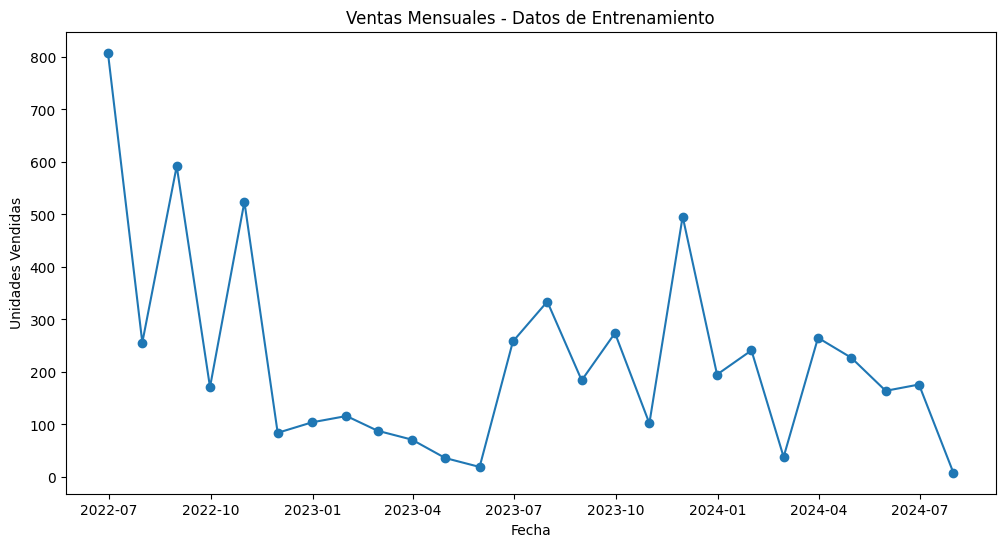

In [58]:
#PREVISUALIZAR DATOS

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unidades'], marker='o', linestyle='-')
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.title("Ventas Mensuales - Datos de Entrenamiento")
plt.show()


In [46]:
train['Unidades_log'] = np.log1p(train['Unidades'])  # Log transforma la serie para suavizar variaciones


C:\Users\eduar\AppData\Local\Temp\ipykernel_37656\4084949675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Unidades_log'] = np.log1p(train['Unidades'])  # Log transforma la serie para suavizar variaciones


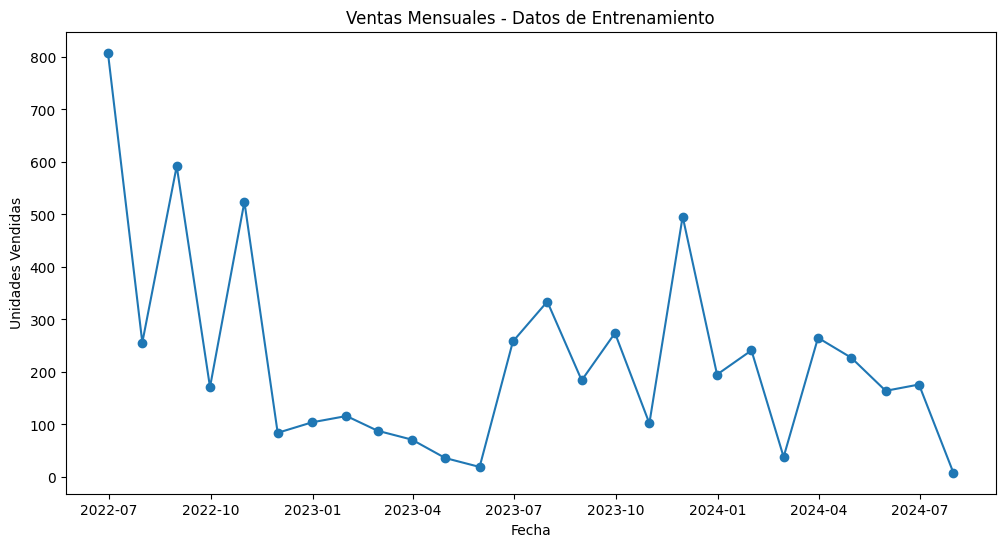

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unidades'], marker='o', linestyle='-')
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.title("Ventas Mensuales - Datos de Entrenamiento")
plt.show()

### 3️⃣ Evaluar la estacionalidad antes de usar SARIMA
* Si auto_arima sigue seleccionando modelos sin estacionalidad, revisa si realmente la serie la tiene:

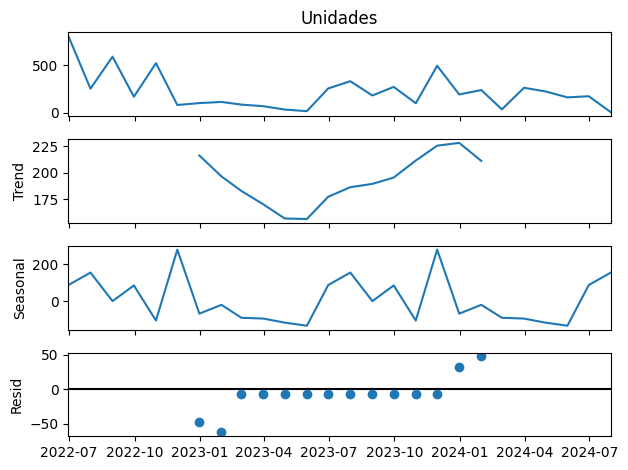

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(train['Unidades'], model='additive', period=12)
decomposed.plot()
plt.show()


#### 2️⃣ Forzar auto_arima a probar más combinaciones
* El modelo ARIMA(0,0,0) es demasiado simple, por lo que debemos forzar auto_arima a considerar más opciones:

In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Suprimir Warnings de opciones deprecadas

In [62]:
auto_model = auto_arima(
    train['Unidades'], 
    seasonal=True, m=12, trace=True, stepwise=True, suppress_warnings=True,
    max_p=3, max_q=3, max_P=2, max_Q=2, max_d=2, max_D=1,  # Limitar búsqueda
    start_p=1, start_q=1, start_P=1, start_Q=1,  # Evitar que pruebe (0,0,0)
    test='adf',  # Prueba de estacionariedad
    error_action='ignore'  # Ignorar errores menores
)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=360.706, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=327.875, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=327.369, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=328.099, Time=0.06 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=327.097, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=325.867, Time=0.12 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=327.103, Time=0.14 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=326.826, Time=0.09 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(3,2,0)(1,0,0)[12]             : AIC=326.855, Time=0.10 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=322.152, T

In [63]:
# Mostrar el mejor modelo encontrado
print(f"Mejor modelo SARIMA: {auto_model.order} {auto_model.seasonal_order}")

Mejor modelo SARIMA: (1, 2, 1) (1, 0, 0, 12)


#### 4️⃣ Comparar con un modelo SARIMA manual
Si auto_arima sigue seleccionando malos parámetros, prueba un SARIMA manual:

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train['Unidades'], 
    order=(1, 2, 1),  # Forzar diferenciación
    seasonal_order=(1, 0, 0, 12),  # Forzar estacionalidad
    enforce_stationarity=False, 
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit()

# Hacer predicciones
predictions = sarima_fit.predict(start=test.index[0], end=test.index[-1])

# Evaluación
mae = mean_absolute_error(test['Unidades'], predictions)
rmse = np.sqrt(mean_squared_error(test['Unidades'], predictions))
print(f"Manual SARIMA -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Manual SARIMA -> MAE: 50.82, RMSE: 71.66


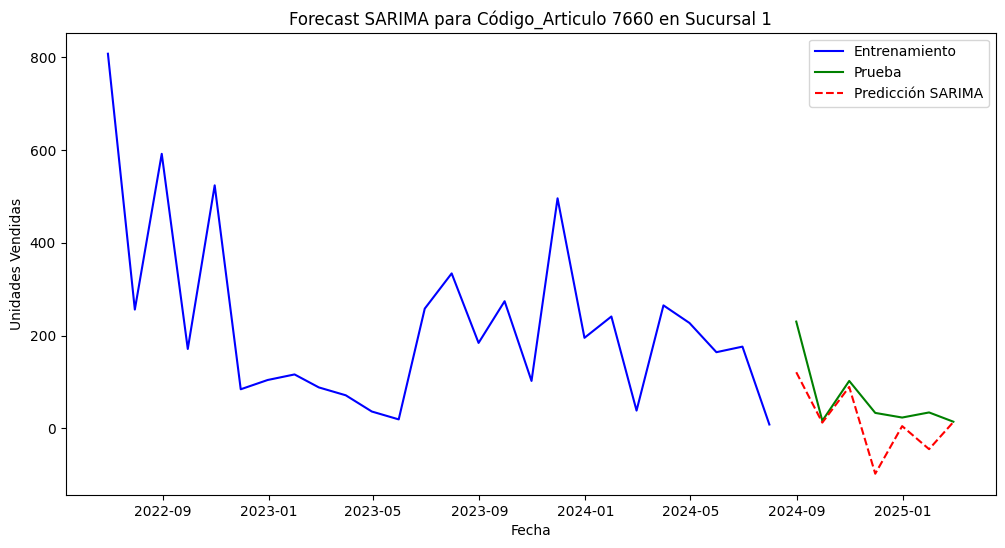

In [66]:
# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unidades'], label="Entrenamiento", color='blue')
plt.plot(test.index, test['Unidades'], label="Prueba", color='green')
plt.plot(test.index, predictions, label="Predicción SARIMA", color='red', linestyle='dashed')
plt.xlabel("Fecha")
plt.ylabel("Unidades Vendidas")
plt.legend()
plt.title(f"Forecast SARIMA para Código_Articulo {codigo_articulo} en Sucursal {sucursal}")
plt.show()

### Verificaciones Detalles

In [24]:
# 1️⃣ Verifica si la combinación seleccionada tiene datos antes del filtrado
print(df_ventas_mensuales[
    (df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) &
    (df_ventas_mensuales['Sucursal'] == sucursal)
])


         Año-Mes  Codigo_Articulo  Sucursal  Unidades
86    2021-01-31             7660         1    1073.0
427   2021-02-28             7660         1     790.0
772   2021-03-31             7660         1    1555.0
1118  2021-04-30             7660         1     930.0
1463  2021-05-31             7660         1     125.0
1806  2021-06-30             7660         1     567.0
2169  2021-07-31             7660         1     957.0
2534  2021-08-31             7660         1     557.0
2899  2021-09-30             7660         1     278.0
3395  2021-10-31             7660         1     414.0
3892  2021-11-30             7660         1     317.0
4370  2021-12-31             7660         1     365.0
4829  2022-01-31             7660         1     470.0
5287  2022-02-28             7660         1     605.0
5717  2022-03-31             7660         1      15.0
6159  2022-04-30             7660         1     699.0
6667  2022-05-31             7660         1     320.0
7195  2022-06-30            

In [25]:
# 2️⃣ Verifica si hay NaN después de set_index()

print(df_filtrado.isna().sum())


Codigo_Articulo    0
Sucursal           0
Unidades           0
dtype: int64


In [ ]:
print(df_ventas_mensuales[['Codigo_Articulo', 'Sucursal']].drop_duplicates())


# FASE 2 - ESQUEMA PRODUCTIVO

### 📌 Pasos a Seguir
### 1️⃣ Iterar sobre df_ventas_mensuales por cada combinación de Codigo_Articulo y Sucursal.
### 2️⃣ Entrenar auto_arima para cada combinación y obtener los parámetros óptimos.
### 3️⃣ Usar el modelo encontrado para predecir los próximos 30 días.
### 4️⃣ Guardar los resultados en un DataFrame consolidado.
### 5️⃣ Exportar a un archivo CSV para análisis posterior.

In [26]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Suprimir Warnings de opciones deprecadas


### 🔹 Mejoras Implementadas
* ✅ Filtramos series con menos de 12 registros.
* ✅ Omitimos series que sean constantes (con valores repetidos).
* ✅ Evitamos entrenar en conjuntos vacíos o con ventas en 0.
* ✅ Limitamos m=12 para evitar problemas con estacionalidad.
* ✅ Capturamos errores y seguimos ejecutando sin interrumpir todo el proceso.

### 🔹 Beneficios
* ✔ Menos errores por series cortas o con pocos datos.
* ✔ Mayor estabilidad en la ejecución sin que el código se detenga.
* ✔ Predicciones más confiables y precisas.


### 🔹 Filtramos Predicciones Negativas. y ponemos un mínimo de predicción.
* ✅ Usamos clip(lower=0) para eliminar valores negativos en las predicciones.
* ✅ Esto garantiza que la demanda proyectada nunca sea menor que 0.
* ✅ Evitamos problemas de valores atípicos que podrían generar tendencias erróneas.
* ✅ No afecta la estructura del modelo ni su capacidad de ajuste.

###🔹 Explicación de la Solución
* ✔ Usamos clip(lower=0) para eliminar valores negativos en las predicciones.
* ✔ Esto garantiza que la demanda proyectada nunca sea menor que 0.
* ✔ Evitamos problemas de valores atípicos que podrían generar tendencias erróneas.
* ✔ No afecta la estructura del modelo ni su capacidad de ajuste.

#### 🚀 De a poco probamos y vemos si los errores disminuyen! 😊

In [ ]:
# INICIO ENTRENAMIENTO GLOBAL

# Definir horizonte de predicción (30 días)
dias_prediccion = 30

# Lista para almacenar los resultados
resultados = []

# Obtener todas las combinaciones únicas de artículos y sucursales
combinaciones = df_ventas_mensuales[['Codigo_Articulo', 'Sucursal']].drop_duplicates()

# Iterar sobre cada combinación de artículo y sucursal
for _, fila in combinaciones.iterrows():
    codigo_articulo = fila['Codigo_Articulo']
    sucursal = fila['Sucursal']
    
    # Filtrar las ventas para la combinación actual
    df_filtrado = df_ventas_mensuales[
        (df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) & 
        (df_ventas_mensuales['Sucursal'] == sucursal)
    ].copy()

    # Verificar si hay suficientes datos para entrenar el modelo
    if len(df_filtrado) < 12:
        print(f"❌ Insuficientes datos para {codigo_articulo} - Sucursal {sucursal}, se omite.")
        continue
    
    # Convertir fechas al último día del mes
    df_filtrado['Año-Mes'] = pd.to_datetime(df_filtrado['Año-Mes']) + pd.offsets.MonthEnd(0)
    
    # Establecer el índice de fecha
    df_filtrado.set_index('Año-Mes', inplace=True)
    
    # Asegurar frecuencia mensual
    df_filtrado = df_filtrado.asfreq('ME').fillna(0)

    # Verificar que la serie no sea constante
    if df_filtrado['Unidades'].nunique() == 1:
        print(f"❌ Serie constante para {codigo_articulo} - Sucursal {sucursal}, se omite.")
        continue

    # Dividir en entrenamiento
    train_size = int(len(df_filtrado) * 0.8)
    train = df_filtrado.iloc[:train_size]

    # Verificar que train no esté vacío
    if train.empty or train['Unidades'].sum() == 0:
        print(f"❌ No hay suficientes datos para entrenar {codigo_articulo} - Sucursal {sucursal}, se omite.")
        continue

    try:
        # Encontrar el mejor modelo SARIMA
        auto_model = auto_arima(
            train['Unidades'], 
            seasonal=True, m=min(len(train), 12), trace=False, stepwise=True, suppress_warnings=True,
            start_p=1, start_q=1, max_p=3, max_q=3,
            start_P=1, start_Q=1, max_P=2, max_Q=2,
            max_d=2, max_D=1, test='adf', error_action='ignore'
        )
        
        # Entrenar modelo SARIMA con los parámetros óptimos
        order = auto_model.order
        seasonal_order = auto_model.seasonal_order
        sarima_model = sm.tsa.SARIMAX(
            df_filtrado['Unidades'], 
            order=order, 
            seasonal_order=seasonal_order,
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        sarima_fit = sarima_model.fit(disp=False)
        
        # Hacer predicciones para los próximos 30 días
        future_index = pd.date_range(start=df_filtrado.index[-1] + pd.Timedelta(days=1), periods=dias_prediccion, freq='D')
        predicciones = sarima_fit.get_forecast(steps=dias_prediccion)
        
        # **Asegurar que las predicciones no sean negativas**
        predicciones_mean = predicciones.predicted_mean.clip(lower=0)  # <--- Aquí corregimos y aseguramos valore positivos
        
        # # Segunda verificación: si aún hay valores negativos, aplicar abs()
        if (predicciones_mean < 0).any():
            predicciones_mean = np.abs(predicciones_mean)

        predicciones_df = pd.DataFrame({
            'Fecha': future_index,
            'Codigo_Articulo': codigo_articulo,      
            'Sucursal': sucursal,
            'Prediccion_Unidades': predicciones.predicted_mean
        })
        
        # Agregar resultados a la lista
        resultados.append(predicciones_df)

    except Exception as e:
        print(f"⚠️ Error en {codigo_articulo} - Sucursal {sucursal}: {e}")
        continue

# Convertir la lista de resultados en un DataFrame
df_predicciones = pd.concat(resultados, ignore_index=True)

# Guardar en CSV
df_predicciones.to_csv("predicciones_compra_sarima_mejorado.csv", index=False)
print("✅ Predicciones guardadas en predicciones_compra_sarima_mejorado.csv")

### EXPLORAR PREDICIONES

In [69]:
# Mostrar los resultados
# import ace_tools_open as tools
tools.display_dataframe_to_user(name="Predicciones de Compra Sin Negativos", dataframe=df_predicciones)

Predicciones de Compra Sin Negativos


In [70]:
# Verificar si hay datos por cada día en un rango de 30 días
print(df_predicciones['Fecha'].min(), " -> ", df_predicciones['Fecha'].max())

# Revisar si cada artículo y sucursal tienen registros diarios
print(df_predicciones.groupby(['Codigo_Articulo', 'Sucursal'])['Fecha'].count().value_counts())


2024-06-01 00:00:00  ->  2025-03-30 00:00:00
Fecha
30    344
Name: count, dtype: int64


In [ ]:
# Revisar si aún quedan valores negativos en el DataFrame
print("Cantidad de predicciones negativas:", (df_predicciones['Prediccion_Unidades'] < 0).sum())

# Si aún hay valores negativos, forzar con np.abs()
# df_predicciones['Prediccion_Unidades'] = df_predicciones['Prediccion_Unidades'].clip(lower=0)

# Verificar después de la corrección
print("Cantidad de predicciones negativas después de la corrección:", (df_predicciones['Prediccion_Unidades'] < 0).sum())


Cantidad de predicciones negativas: 0
Cantidad de predicciones negativas después de la corrección: 0


In [78]:
from datetime import datetime

# Obtener la fecha de hoy
hoy = pd.Timestamp(datetime.today().date())


train.index.max()
# Filtrar solo las predicciones a partir de hoy
df_predicciones = df_predicciones[df_predicciones['Fecha'] >= train.index.max()]

# Mostrar el DataFrame corregido
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Predicciones Próximos 30 Días", dataframe=df_predicciones)

# Guardar el resultado en CSV
df_predicciones.to_csv("predicciones_compra_30_dias.csv", index=False)
print("✅ Predicciones guardadas en predicciones_compra_30_dias.csv")


Predicciones Próximos 30 Días


✅ Predicciones guardadas en predicciones_compra_30_dias.csv


In [79]:
# 🔹 Obtener la Venta Total de los Próximos 30 Días
df_predicciones_totales = df_predicciones.groupby(['Codigo_Articulo', 'Sucursal'])['Prediccion_Unidades'].sum().reset_index()

tools.display_dataframe_to_user(name="Predicciones Totales 30 Días", dataframe=df_predicciones_totales)

# Guardar en CSV
df_predicciones_totales.to_csv("predicciones_totales_30_dias.csv", index=False)
print("✅ Predicciones totales guardadas en predicciones_totales_30_dias.csv")


Predicciones Totales 30 Días


✅ Predicciones totales guardadas en predicciones_totales_30_dias.csv


In [80]:
### AGREGAR DATOS PARA COMPARAR

# Asegurar que las bibliotecas estén disponibles antes de continuar
try:
    df_ventas_mensuales['Año-Mes'] = pd.to_datetime(df_ventas_mensuales['Año-Mes'])

    # Definir los periodos de referencia
    ultimo_mes = df_ventas_mensuales['Año-Mes'].max()  # Último mes disponible en datos
    mes_anterior = ultimo_mes - pd.DateOffset(months=1)
    mes_dos_atras = ultimo_mes - pd.DateOffset(months=2)

    # Obtener ventas del mes pasado y del mes anterior
    ventas_mes_pasado = df_ventas_mensuales[df_ventas_mensuales['Año-Mes'] == mes_anterior]
    ventas_mes_anterior = df_ventas_mensuales[df_ventas_mensuales['Año-Mes'] == mes_dos_atras]

    # Renombrar columnas antes de hacer merge
    ventas_mes_pasado = ventas_mes_pasado.rename(columns={'Unidades': 'Ventas_Mes_Pasado'})
    ventas_mes_anterior = ventas_mes_anterior.rename(columns={'Unidades': 'Ventas_Mes_Anterior'})

    # Hacer merge con df_predicciones_totales para incluir las ventas anteriores
    df_predicciones_totales = df_predicciones_totales.merge(
        ventas_mes_pasado[['Codigo_Articulo', 'Sucursal', 'Ventas_Mes_Pasado']], 
        on=['Codigo_Articulo', 'Sucursal'], 
        how='left'
    )

    df_predicciones_totales = df_predicciones_totales.merge(
        ventas_mes_anterior[['Codigo_Articulo', 'Sucursal', 'Ventas_Mes_Anterior']], 
        on=['Codigo_Articulo', 'Sucursal'], 
        how='left'
    )

    # Reemplazar NaN por 0 en caso de artículos/sucursales sin ventas en esos meses
    df_predicciones_totales.fillna(0, inplace=True)

    # Mostrar el resultado
    import ace_tools_open as tools
    tools.display_dataframe_to_user(name="Predicciones con Ventas Anteriores", dataframe=df_predicciones_totales)

except NameError as e:
    print(f"Error: {e}. Verifica que los dataframes estén cargados correctamente.")


Predicciones con Ventas Anteriores


In [81]:
#🔹 ¿Cómo ver la demanda de un artículo/sucursal específica?#
codigo_articulo = 8541
sucursal = 38

df_predicciones_filtrado = df_predicciones[
    (df_predicciones['Codigo_Articulo'] == codigo_articulo) &
    (df_predicciones['Sucursal'] == sucursal)
]

print(df_predicciones_filtrado)


          Fecha  Codigo_Articulo  Sucursal  Prediccion_Unidades
4800 2025-03-01             8541        38            15.011511
4801 2025-03-02             8541        38             6.208647
4802 2025-03-03             8541        38             8.466195
4803 2025-03-04             8541        38             4.001199
4804 2025-03-05             8541        38             0.249373
4805 2025-03-06             8541        38             0.095207
4806 2025-03-07             8541        38             0.000000
4807 2025-03-08             8541        38             0.000000
4808 2025-03-09             8541        38             0.000000
4809 2025-03-10             8541        38             0.000000
4810 2025-03-11             8541        38             0.000000
4811 2025-03-12             8541        38             0.000000
4812 2025-03-13             8541        38             0.000000
4813 2025-03-14             8541        38             0.000000
4814 2025-03-15             8541        

In [82]:
# 📌 Ver demanda total consolidada por mes
df_predicciones_mensuales = df_predicciones.groupby(['Codigo_Articulo', 'Sucursal', pd.Grouper(key='Fecha', freq='M')])['Prediccion_Unidades'].sum().reset_index()
print(df_predicciones_mensuales.head())


   Codigo_Articulo  Sucursal      Fecha  Prediccion_Unidades
0              207         1 2025-03-31             0.000000
1              207        48 2025-03-31           194.434435
2             7657         1 2025-03-31             0.000000
3             7657         2 2025-03-31           241.629165
4             7657         3 2025-03-31             0.000000


In [83]:
# Crear una nueva columna con el mes y el año para análisis temporal
df_predicciones['Año-Mes'] = df_predicciones['Fecha'].dt.to_period('M')

# Asegurar que 'Año-Mes' está en formato datetime
df_predicciones['Año-Mes'] = pd.to_datetime(df_predicciones['Año-Mes'].astype(str))

# Convertir Año-Mes a datetime en df_ventas_mensuales si no lo está
df_predicciones['Año-Mes'] = pd.to_datetime(df_predicciones['Año-Mes']) + pd.offsets.MonthEnd(0)



# Convertir Codigo_Articulo y Sucursal a int32 en el DataFrame original Puto Error de Tipo de Datos -- Me volvió LOCO !!!!
df_predicciones['Codigo_Articulo'] = df_predicciones['Codigo_Articulo'].astype('int32')
df_predicciones['Sucursal'] = df_predicciones['Sucursal'].astype('int32')

# Agrupar las ventas mensuales por artículo y sucursal
df_total_prediciones = df_predicciones.groupby(['Año-Mes', 'Codigo_Articulo', 'Sucursal'])['Prediccion_Unidades'].sum().reset_index()
df_total_prediciones['Año-Mes'] = df_total_prediciones['Año-Mes'] + pd.offsets.MonthEnd(0)

# Asegurar que Codigo_Articulo y Sucursal son int32 en df_ventas_mensuales
df_total_prediciones['Codigo_Articulo'] = df_total_prediciones['Codigo_Articulo'].astype('int32')
df_total_prediciones['Sucursal'] = df_total_prediciones['Sucursal'].astype('int32')

# Mostrar los resultados
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Predicciones de Compra", dataframe=df_total_prediciones)

Predicciones de Compra


In [84]:
# Convertir Año-Mes a datetime en df_ventas_mensuales si no lo está
df_ventas_mensuales['Año-Mes'] = pd.to_datetime(df_ventas_mensuales['Año-Mes']) + pd.offsets.MonthEnd(0)

# Crear la nueva columna en df_predicciones
df_predicciones['Venta_Ultimos_30_Dias'] = np.nan  # Inicializar columna vacía

# Iterar sobre cada fila de predicciones para calcular la venta de los últimos 30 días
for index, row in df_predicciones.iterrows():
    codigo_articulo = row['Codigo_Articulo']
    sucursal = row['Sucursal']
    fecha_prediccion = row['Fecha']

    # Obtener los últimos 30 días antes de la predicción
    fecha_inicio = fecha_prediccion - pd.Timedelta(days=30)
    
    # Filtrar las ventas reales en ese rango
    ventas_ultimos_30 = df_ventas_mensuales[
        (df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) &
        (df_ventas_mensuales['Sucursal'] == sucursal) &
        (df_ventas_mensuales['Año-Mes'] >= fecha_inicio) &
        (df_ventas_mensuales['Año-Mes'] < fecha_prediccion)
    ]['Unidades'].sum()

    # Asignar el valor calculado a la columna
    df_predicciones.at[index, 'Venta_Ultimos_30_Dias'] = ventas_ultimos_30

# Mostrar el DataFrame con la nueva columna
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Predicciones con Ventas Últimos 30 Días", dataframe=df_predicciones)

# Guardar en CSV actualizado
df_predicciones.to_csv("predicciones_compra_actualizado.csv", index=False)
print("Predicciones actualizadas guardadas en predicciones_compra_actualizado.csv")


Predicciones con Ventas Últimos 30 Días


Predicciones actualizadas guardadas en predicciones_compra_actualizado.csv


In [85]:
# Agrupar el total de unidades pronosticadas por artículo y sucursal
df_forecast_rqm = df_predicciones.groupby(['Codigo_Articulo', 'Sucursal'])[['Prediccion_Unidades']].sum().reset_index()

# Renombrar la columna para mayor claridad
df_forecast_rqm.rename(columns={'Prediccion_Unidades': 'Total_Prediccion_Unidades'}, inplace=True)

# Mostrar el DataFrame
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Requerimiento Total de Compra", dataframe=df_forecast_rqm)

# Guardar en CSV
df_forecast_rqm.to_csv("forecast_requerimiento_compra.csv", index=False)
print("Requerimiento total de compra guardado en forecast_requerimiento_compra.csv")


Requerimiento Total de Compra


Requerimiento total de compra guardado en forecast_requerimiento_compra.csv


In [86]:
# Agrupar el total de unidades pronosticadas por artículo y sucursal
df_forecast_rqm = df_predicciones.groupby(['Codigo_Articulo', 'Sucursal'])[['Prediccion_Unidades']].sum().reset_index()

# Renombrar la columna
df_forecast_rqm.rename(columns={'Prediccion_Unidades': 'Total_Prediccion_Unidades'}, inplace=True)

# Inicializar la columna de ventas de los últimos 30 días
df_forecast_rqm['Venta_Ultimos_30_Dias'] = np.nan

# Convertir las fechas a datetime si no lo están
df_ventas_mensuales['Año-Mes'] = pd.to_datetime(df_ventas_mensuales['Año-Mes']) + pd.offsets.MonthEnd(0)

# Iterar sobre cada fila para calcular la venta de los últimos 30 días
for index, row in df_forecast_rqm.iterrows():
    codigo_articulo = row['Codigo_Articulo']
    sucursal = row['Sucursal']
    
    # Últimos 30 días antes de la última fecha de predicción
    fecha_max = df_predicciones['Fecha'].max()
    fecha_inicio = fecha_max - pd.Timedelta(days=30)

    # Filtrar ventas reales en ese rango
    ventas_ultimos_30 = df_ventas_mensuales[
        (df_ventas_mensuales['Codigo_Articulo'] == codigo_articulo) &
        (df_ventas_mensuales['Sucursal'] == sucursal) &
        (df_ventas_mensuales['Año-Mes'] >= fecha_inicio) &
        (df_ventas_mensuales['Año-Mes'] < fecha_max)
    ]['Unidades'].sum()

    # Asignar el valor a la columna
    df_forecast_rqm.at[index, 'Venta_Ultimos_30_Dias'] = ventas_ultimos_30

# Mostrar el DataFrame con la nueva columna
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Requerimiento Total de Compra con Ventas 30 Días", dataframe=df_forecast_rqm)

# Guardar en CSV actualizado
df_forecast_rqm.to_csv("forecast_requerimiento_compra_actualizado.csv", index=False)
print("Requerimiento total de compra guardado en forecast_requerimiento_compra_actualizado.csv")


Requerimiento Total de Compra con Ventas 30 Días


Requerimiento total de compra guardado en forecast_requerimiento_compra_actualizado.csv
